In [1]:
import numpy as np
import pickle as pkl
import pandas as pd
from sklearn.cluster import MiniBatchKMeans
from itertools import cycle

import matplotlib.pyplot as plt
import matplotlib.colors as colors
%matplotlib inline

plt.rcParams['figure.figsize'] = (8, 8)


In [2]:
df = pd.read_csv('../../data/Sepsis_imp.csv')

In [3]:
observations =   ['gender','age','elixhauser','re_admission','SOFA','SIRS','Weight_kg','GCS','HR',
                  'SysBP','MeanBP','DiaBP','Shock_Index','RR','SpO2','Temp_C','FiO2_1','Potassium',
                  'Sodium','Chloride','Glucose','BUN','Creatinine','Magnesium','Calcium','Ionised_Ca',
                  'CO2_mEqL','SGOT','SGPT','Total_bili','Albumin','Hb','WBC_count','Platelets_count',
                  'PTT','PT','INR','Arterial_pH','paO2','paCO2','Arterial_BE','Arterial_lactate','HCO3',
                  'PaO2_FiO2','output_total','output_4hourly','sedation','mechvent','rrt']
# Per homework, 'sedation','mechvent','rrt' are considered observations, not interventions.
interventions = ['input_4hourly_tev','max_dose_vaso']

results = ['died_in_hosp','mortality_90d']

X = df[observations]


In [4]:
n_clusters = 750
mbk = MiniBatchKMeans(init='k-means++', n_clusters=n_clusters, batch_size=100,
                      n_init=10, max_no_improvement=10, verbose=0, init_size=3*n_clusters,
                      random_state=0)
mbk.fit(X)
mbk_means_labels_unique = np.unique(mbk.labels_)

In [5]:
mbk.labels_

array([721, 721,  37, ..., 649, 649,  67], dtype=int32)

In [6]:
mbk.cluster_centers_

array([[  3.75000000e-01,   2.54353283e+04,   4.25000000e+00, ...,
          0.00000000e+00,   1.25000000e-01,   0.00000000e+00],
       [  1.00000000e+00,   2.79022778e+04,   3.00000000e+00, ...,
          0.00000000e+00,   5.00000000e-01,   0.00000000e+00],
       [  2.00000000e-01,   1.62233909e+04,   3.00000000e+00, ...,
          4.00000000e-01,   4.00000000e-01,   0.00000000e+00],
       ..., 
       [  6.00000000e-01,   1.48480491e+04,   4.00000000e+00, ...,
          6.00000000e-01,   6.00000000e-01,   0.00000000e+00],
       [  4.28571429e-01,   2.72899719e+04,   5.85714286e+00, ...,
          2.85714286e-01,   4.28571429e-01,   0.00000000e+00],
       [  6.00000000e-01,   2.20287776e+04,   5.80000000e+00, ...,
          0.00000000e+00,   2.00000000e-01,   0.00000000e+00]])

In [7]:
# Because many blocs contain zero dose of vasopressor or zero dose or IV fluids, put zero 
# values into its own bin and evenly distribute the remaining values.
n_actions = 25
def non_zero_bins(s):
    out, retbins = pd.qcut(s.where(s >= 0.001),4,retbins=True,labels=False)
    retbins = np.insert(retbins,0,float('-inf'))
    return pd.cut(s,retbins,labels=False)

vaso_bins = non_zero_bins(df['max_dose_vaso'])
tev_bins = non_zero_bins(df['cumulated_balance_tev'])
print("Vasopressor bins counts:\n",vaso_bins.value_counts())
print("IV fluid bin counts:\n",tev_bins.value_counts())


Vasopressor bins counts:
 0    208663
2     12692
1     11163
4     10619
3      9067
Name: max_dose_vaso, dtype: int64
IV fluid bin counts:
 0    86623
4    41396
3    41395
2    41395
1    41395
Name: cumulated_balance_tev, dtype: int64


In [8]:
d = {'state': mbk.labels_, 'action':vaso_bins*5 + tev_bins, 'reward': df[results].sum(axis=1), 
     'bloc':df.bloc, 'id':df.icustayid }
mdp = pd.DataFrame(data = d)
episodes = mdp.sort_values(['id','bloc']).groupby('id')
mdp.head(5)

,action,bloc,id,reward,state
0,2,1,3,1,721
1,3,2,3,1,721
2,2,3,3,1,37
3,2,4,3,1,105
4,2,5,3,1,105


In [9]:
state_action_count = np.zeros((n_clusters, n_actions))

for i in range(len(mdp)):
    s= mdp.state[i]
    a= mdp.action[i]
    state_action_count[s,a] += 1




In [14]:
mdp.head()

,action,bloc,id,reward,state
0,2,1,3,1,721
1,3,2,3,1,721
2,2,3,3,1,37
3,2,4,3,1,105
4,2,5,3,1,105


In [18]:
mdp.state[2]

37

In [19]:
sas_count = np.zeros((n_clusters, n_actions))

i =0
for name, transitions in episodes:
    state = transitions['state'].tolist()
    action = transitions['action'].tolist()
    for i in range(len(state)-2):
        sas_count[state[i],action[i]] += 1

In [20]:
sas_nul_count = np.count_nonzero(sas_count==0.0)
print ("Number of null items:",sas_nul_count, " out of ", n_clusters*n_actions)
sparsity = 100*(1 - (n_clusters*n_actions - sas_nul_count) / (n_clusters*n_actions)) 
print ("The state-action-sprime matrix is {0:.2f}% sparse".format(sparsity))
distinct_sas_count = sorted(sas_count[np.nonzero(sas_count)],reverse=True)
print ("Total number of distinct state, action, sprime tuples:",len(distinct_sas_count))

Number of null items: 6909  out of  18750
The state-action-sprime matrix is 36.85% sparse
Total number of distinct state, action, sprime tuples: 11841


In [24]:
state_action_count[0:5]

array([[ 168.,   89.,   81.,  130.,   61.,    5.,    7.,    2.,    8.,
           6.,    6.,    4.,    3.,   13.,    6.,    2.,    0.,    3.,
           7.,    5.,    7.,    2.,    9.,    3.,    7.],
       [  63.,    0.,    0.,    0.,   20.,   14.,    0.,    0.,    0.,
           0.,    6.,    0.,    0.,    0.,    0.,    3.,    0.,    0.,
           0.,    0.,    4.,    0.,    0.,    0.,    0.],
       [ 111.,   54.,   84.,   87.,   85.,    2.,    4.,    2.,    2.,
           1.,    1.,    1.,    2.,    5.,    4.,    2.,    0.,    0.,
           5.,    5.,    0.,    3.,    0.,    2.,    0.],
       [  62.,   14.,   11.,    6.,   16.,    3.,    0.,    0.,    0.,
           0.,    7.,    2.,    0.,    0.,    0.,    2.,    0.,    0.,
           2.,    0.,    2.,    0.,    0.,    1.,    0.],
       [  73.,   54.,   52.,   26.,   11.,    2.,    4.,    3.,    1.,
           1.,    2.,    2.,    1.,    0.,    1.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    1.,    0.]])

In [37]:
f = np.sum(state_action_count != 0, axis = 1)
f[0:10]

array([24,  6, 20, 12, 15,  3,  7, 16, 12, 24])

In [38]:
g = np.sum(state_action_count > 30, axis = 1)
g[0:10]

array([5, 1, 5, 1, 3, 1, 0, 4, 4, 5])

In [27]:
nul_count = np.count_nonzero(state_transition_count==0.0)
print ("Number of null transitions:",nul_count, " out of ", n_clusters*n_clusters)
sparsity = 100*(1 - (n_clusters*n_clusters - nul_count) / (n_clusters*n_clusters)) 
print ("The state transitions are {0:.2f}% sparse".format(sparsity))
t_count = sorted(state_transition_count[np.nonzero(state_transition_count)],reverse=True)
print ("Total number of different transitions:",len(t_count))

NameError: name 'state_transition_count' is not defined

In [30]:
np.count_nonzero(state_action_count, axis=1)

array([24,  6, 20, 12, 15,  3,  7, 16, 12, 24, 15,  9, 10, 17, 10, 22,  7,
       14,  9,  5, 23, 21, 16, 21, 18, 25,  7,  4, 10, 23, 25,  7,  3,  6,
       15, 24, 19, 24,  6, 12, 17,  6, 14, 17, 14, 13, 10,  9, 25, 16, 20,
        7, 25, 12,  8, 19, 12,  8, 12, 18, 25, 23, 20, 12, 13, 10, 13, 16,
        5, 20, 23, 11, 23,  7, 19, 14, 23, 18, 18, 18, 20, 23, 24, 22, 14,
       25, 23, 24,  8,  9, 24, 12, 20, 12, 22, 22, 14, 25, 14, 15,  4, 22,
       10,  9, 15, 22, 10,  3, 17,  9,  4, 23, 20, 11, 18,  8, 22, 21, 23,
       20,  9, 17, 15,  4,  5,  7, 13, 21, 10, 24, 20, 12, 18, 18, 25, 12,
       21, 24, 25, 21, 20, 16, 18, 25, 18, 14,  8, 12, 22,  4, 20,  4,  9,
       24, 23, 21, 13, 17, 11,  7, 22, 25, 16, 12, 10, 23, 24,  9, 21, 10,
       11, 15, 22, 25, 21, 22,  3, 14, 16, 20, 14,  9, 12, 14,  6,  6,  8,
       14,  9, 23, 24,  8, 12, 18,  8, 20,  8, 23, 24, 17, 15, 25, 17, 12,
        6,  6, 10,  5, 10,  8, 15, 22, 15, 12, 11, 10, 10, 11,  7, 12, 12,
       13, 10,  3, 22, 12

In [36]:
state_action_count[0:20]

array([[ 168.,   89.,   81.,  130.,   61.,    5.,    7.,    2.,    8.,
           6.,    6.,    4.,    3.,   13.,    6.,    2.,    0.,    3.,
           7.,    5.,    7.,    2.,    9.,    3.,    7.],
       [  63.,    0.,    0.,    0.,   20.,   14.,    0.,    0.,    0.,
           0.,    6.,    0.,    0.,    0.,    0.,    3.,    0.,    0.,
           0.,    0.,    4.,    0.,    0.,    0.,    0.],
       [ 111.,   54.,   84.,   87.,   85.,    2.,    4.,    2.,    2.,
           1.,    1.,    1.,    2.,    5.,    4.,    2.,    0.,    0.,
           5.,    5.,    0.,    3.,    0.,    2.,    0.],
       [  62.,   14.,   11.,    6.,   16.,    3.,    0.,    0.,    0.,
           0.,    7.,    2.,    0.,    0.,    0.,    2.,    0.,    0.,
           2.,    0.,    2.,    0.,    0.,    1.,    0.],
       [  73.,   54.,   52.,   26.,   11.,    2.,    4.,    3.,    1.,
           1.,    2.,    2.,    1.,    0.,    1.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    1.,    0.],


In [34]:
750*25

18750

(array([  10.,   30.,   65.,   66.,   75.,   92.,   54.,   99.,   80.,  179.]),
 array([  1. ,   3.4,   5.8,   8.2,  10.6,  13. ,  15.4,  17.8,  20.2,
         22.6,  25. ]),
 <a list of 10 Patch objects>)

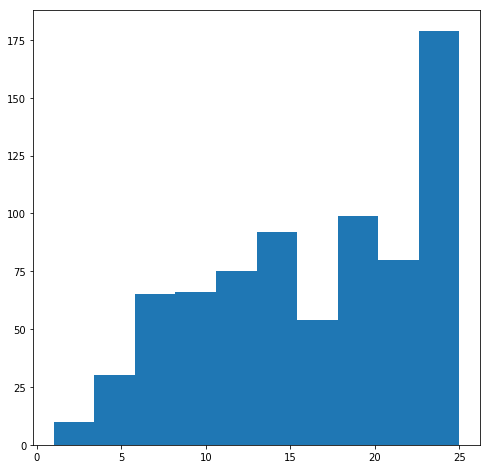

In [28]:
plt.hist(f)

(array([ 124.,  190.,   78.,   38.,   57.,  237.,   20.,    4.,    1.,    1.]),
 array([ 0. ,  0.9,  1.8,  2.7,  3.6,  4.5,  5.4,  6.3,  7.2,  8.1,  9. ]),
 <a list of 10 Patch objects>)

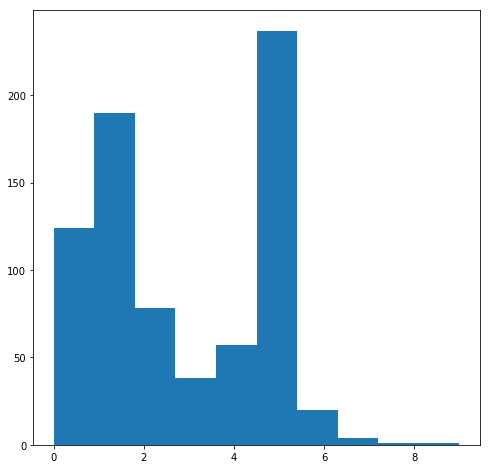

In [39]:
plt.hist(g)

In [32]:
psa = state_action_count/ np.sum(state_action_count, axis = 1)[:, np.newaxis]

(array([  57.,    0.,  146.,    0.,  165.,    0.,  228.,    0.,  153.,    1.]),
 array([ 1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5,  5. ,  5.5,  6. ]),
 <a list of 10 Patch objects>)

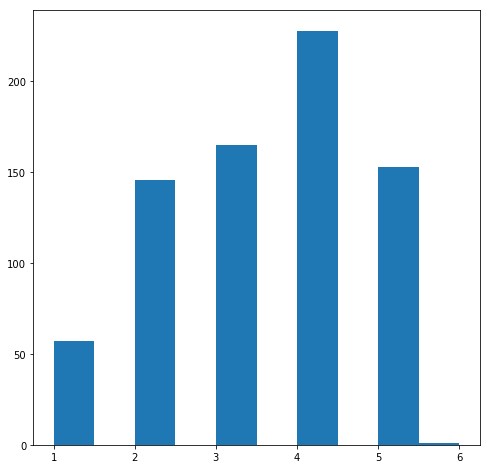

In [33]:
f2 = np.sum(psa>0.1, axis = 1)
plt.hist(f2)

# Random policy

In [ ]:
mdp.groupby('id')

In [ ]:
df.columns